In [1]:
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import numpy as np

sys.path.append(os.path.abspath("Ladder/src/codebase"))

from prompts.gpt4_prompt import create_NIH_prompts, create_RSNA_prompts, create_CELEBA_prompts, \
    create_Waterbirds_prompts, create_Metashift_prompts

%matplotlib inline

In [11]:
clf_results_csv="Ladder/out/NIH/resnet50/seed0/clip_img_encoder_swin-tiny-cxr-clip_mc/valid_pneumothorax_dataframe_mitigation.csv" 
top50_err_text="Ladder/out/NIH/resnet50/seed0/clip_img_encoder_swin-tiny-cxr-clip_mc/pneumothorax_error_top_100_sent_diff_emb.txt"
img_path = Path("Ladder/data/nih/nih_processed_v2.csv")

discover_log_txt = "Ladder/out/NIH/resnet50/seed0/clip_img_encoder_swin-tiny-cxr-clip_mc/ladder_discover_slices_performance_ERM.txt"
validation_log_txt = "Ladder/out/NIH/resnet50/seed0/clip_img_encoder_swin-tiny-cxr-clip_mc/ladder_validate_slices_w_LLM-pneumothorax.txt"

mitigate_log_txt = "Ladder/out/NIH/resnet50/seed0/clip_img_encoder_swin-tiny-cxr-clip_mc/ladder_mitigate_slices.txt"


### Original model (ERM) performance

In [7]:
print("Original ERM model performance: ")
with open(discover_log_txt, 'r') as file:
    content = file.read()
    print(content)

Original ERM model performance: 
Accuracy for Pneumothorax patients with tube: 0.9043824701195219
Accuracy for Pneumothorax patients without  tube (Worst Group): 0.6002886002886003
Accuracy for Pneumothorax overall patients: 0.6811440677966102


AUROC for overall (Mean): 0.8633091283585222
AUROC for positive disease with  tube vs all negatives: 0.9523825353497848
AUROC for positive disease without  tube vs all negatives: 0.8310473315983391



### After mitigation model performance (Sec. 3.3 in the paper)¶

In [8]:
print("After mitigation model performance: ")
with open(mitigate_log_txt, 'r') as file:
    content = file.read()
    print(content)

After mitigation model performance: 
Accuracy for Pneumothorax patients with tube: 0.9307692307692308
Accuracy for Pneumothorax patients without  tube (Worst Group): 0.7624309392265194
Accuracy for Pneumothorax overall patients: 0.806910569105691


AUROC for overall (Mean): 0.9269575299875843
AUROC for positive disease with  tube vs all negatives: 0.9593856185883952
AUROC for positive disease without  tube vs all negatives: 0.9153120838049725



### Validation phase for discovering biases (Sec. 3.2 in the paper)

In [12]:
print(f"Biases for Pneumothroax class:")
with open(validation_log_txt, 'r') as file:
    content = file.read()
    print(content)

Biases for Pneumothroax class:
Hypothesis Dictionary:
{'H1': 'The classifier is making mistakes as it is biased toward the presence of chest tubes.', 'H2': 'The classifier is making mistakes as it is biased toward the presence of fluid in the pneumothorax (hydropneumothorax).', 'H3': 'The classifier is making mistakes as it is biased toward the size and location of the pneumothorax (e.g., basal, apical, loculated).', 'H4': 'The classifier is making mistakes as it is biased toward the change in pneumothorax size or fluid content over time (interval changes).', 'H5': 'The classifier is making mistakes as it is biased toward the presence of associated pleural effusion.'}

Prompt Dictionary:
{'H1_chest tubes': ['Chest X-ray showing a pneumothorax with multiple chest tubes in place.', 'Image of a pneumothorax with a chest tube, clearly visible.', 'Pneumothorax with indwelling chest tube, demonstrating successful drainage.', 'X-ray exhibiting a pneumothorax and the presence of multiple chest

### Prompt details

In [43]:
with open(top50_err_text, "r") as file:
    content = file.read()

prompt = create_NIH_prompts(content)
print(prompt)


    Context: Pneumothorax classification from chest-x-rays using a deep neural network
    Analysis post training: On a validation set, 
    a. Get the difference between the image embeddings of correct and incorrectly classified samples to estimate the features present in the correctly classified samples but missing in the misclassified samples.
    b. Retrive the top 50 sentences from radiology report that matches closely to the embedding difference in step a.
    c. The sentence list is given below:
    1. perhaps mild increase in hydropneumothorax but with chest tube remaining in place and no striking change
2. in comparison with the study of ___ , there is little change in the 3 left chest tubes with area of hydro pneumothorax persisting in the lateral aspect of the upper left chest as well as probably the left lung base
3. a moderate sized loculated hydropneumothorax demonstrates decrease in fluid component and increasing gas component , particularly in the right base
4. small r

### Qualitative examples

In [35]:
n_samples = 100
ddf = pd.read_csv(clf_results_csv)
ddf["pred_bin"] = (ddf["out_put_predict"]>=0.5).astype(int)
ddf["filename"] = ddf["img_path"]
print(ddf.columns)

Index(['out_put_GT', 'out_put_predict', 'tube', 'effusion', 'img_path',
       'Predictions_bin', 'H1_chest tubes', 'H1_chest tubes_bin',
       'H2_fluid in pneumothorax', 'H2_fluid in pneumothorax_bin',
       'H3_size and location', 'H3_size and location_bin',
       'H4_interval changes', 'H4_interval changes_bin', 'H5_pleural effusion',
       'H5_pleural effusion_bin', 'pred_bin', 'filename'],
      dtype='object')


In [46]:
def display_sorted_images(
    ddf,
    img_path,
    sort_column,
    n_samples=12,
    gt_filter=1,
    title_prefix="Samples",
    columns=3,
    image_size=(224, 224),
    caption_fontsize=10
):
    df = ddf.copy()

    filtered_df = df[df["out_put_GT"] == gt_filter]
    sorted_df = filtered_df.sort_values(by=sort_column, ascending=False).reset_index(drop=True)

    top_df = sorted_df.head(n_samples)
    bottom_df = sorted_df.tail(n_samples)

    def plot(df_part, title):
        rows = (len(df_part) + columns - 1) // columns
        fig, axs = plt.subplots(rows, columns, figsize=(5 * columns, 5 * rows))
        axs = axs.flatten()

        for ax, (_, row) in zip(axs, df_part.iterrows()):
            image_path = row["filename"]
#             print(image_path)
            image = Image.open(image_path).convert("RGB").resize(image_size)
            ax.imshow(image)
            ax.axis('off')
        
        for ax in axs[len(df_part):]:
            ax.axis('off')

        fig.suptitle(title, fontsize=16, weight='bold')
        plt.tight_layout()
        plt.subplots_adjust(top=0.93)
        plt.show()

    plot(top_df, f"Class: {title_prefix}, Top {n_samples} images aligned with the bias {sort_column}")

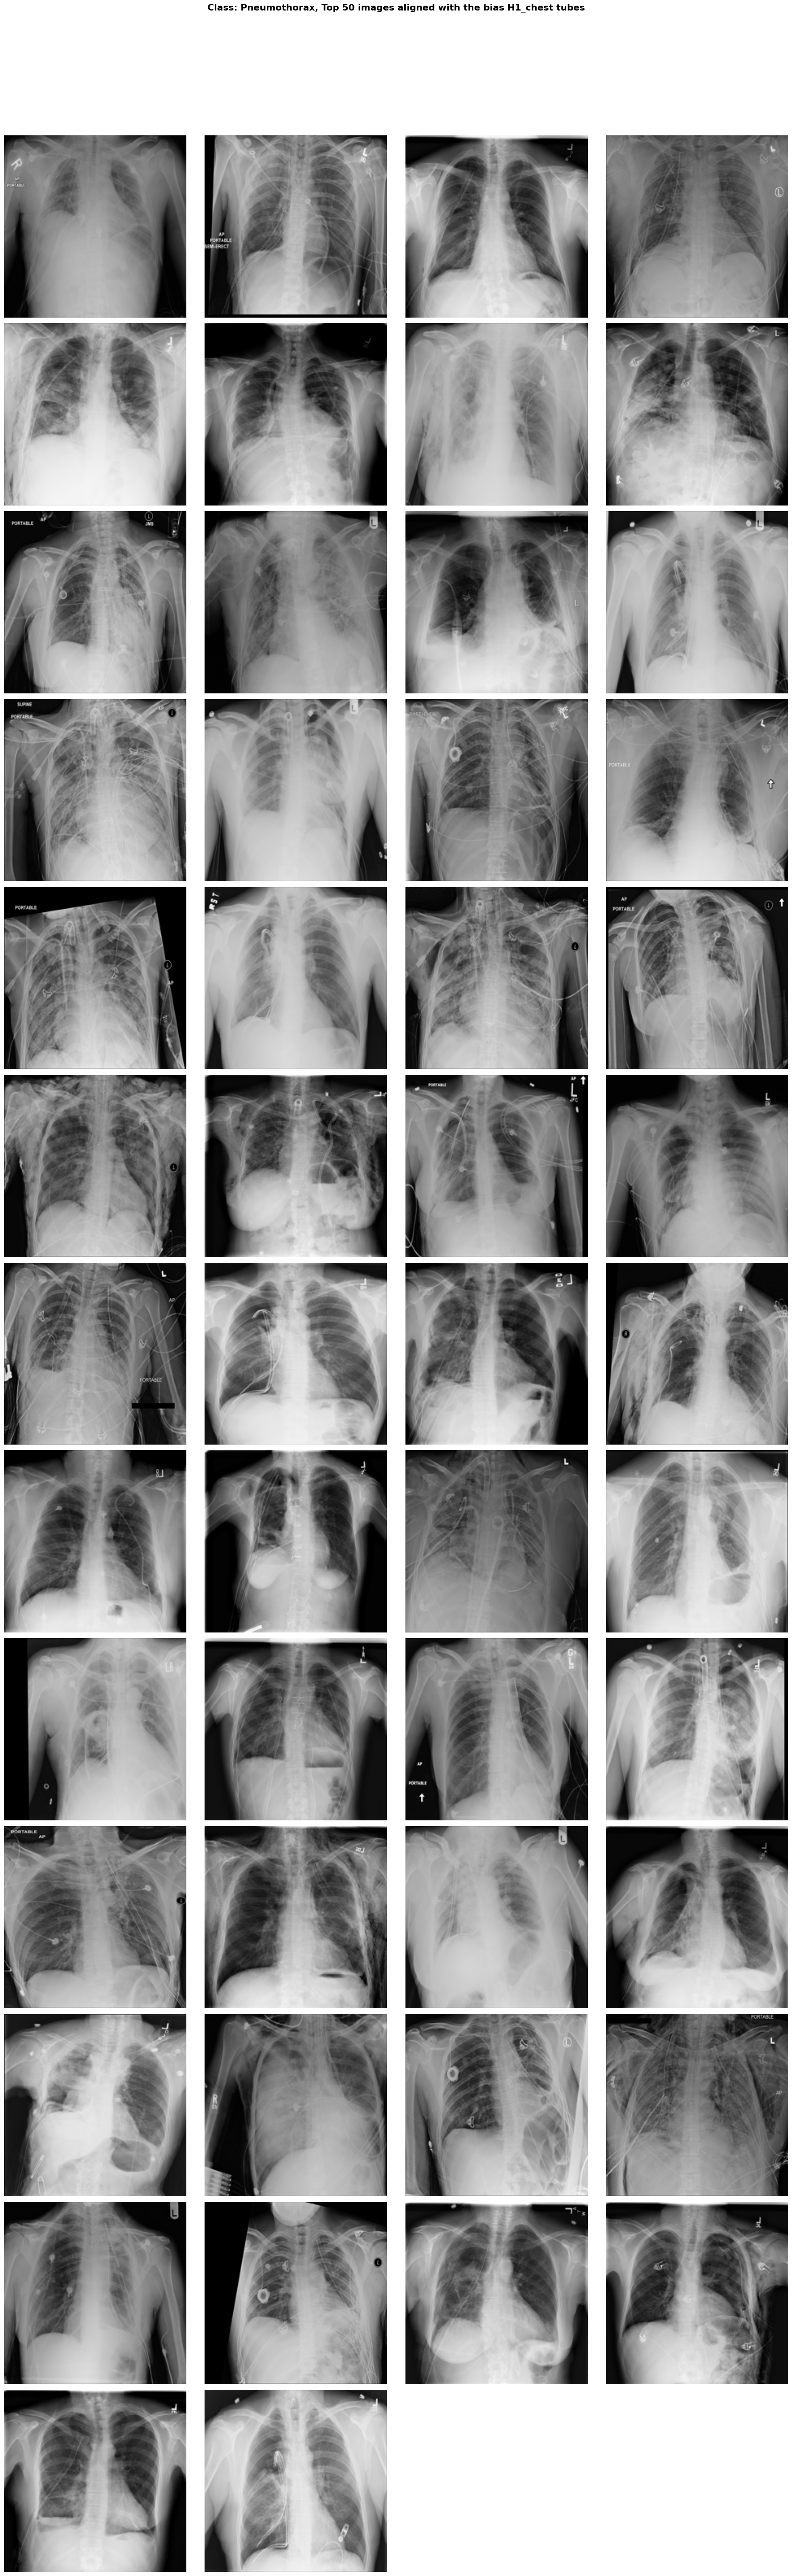

In [47]:
display_sorted_images(
    ddf=ddf,
    img_path=img_path,
    sort_column="H1_chest tubes",
    n_samples=50,
    gt_filter=1,
    title_prefix="Pneumothorax",
    columns=4,
    caption_fontsize=12
)